# MemN으로 한국어 QA 해보기

한국어 Babi 데이터셋에 대해서 메모리 네트워크를 테스트해보겠습니다.

## 1. 커스터마이즈드 KoNLPy 사용하기

사실 위 문장에서 '은경이'는 사람 이름이므로 제대로 된 결과를 얻기 위해서는 '은', '경이'와 같이 글자가 분리되는 것이 아니라 '은경이' 또는 최소한 '은경'이라는 단어 토큰을 얻어야만 합니다. 이런 경우에는 형태소 분석기에 사용자 사전을 추가해줄 수 있습니다. '은경이'는 하나의 단어이기 때문에 분리하지말라고 형태소 분석기에 알려주는 것입니다.

사용자 사전을 추가하는 방법은 형태소 분석기마다 다른데, 생각보다 복잡한 경우들이 많습니다. 이번 실습에서는 Customized Konlpy라는 사용자 사전 추가가 매우 쉬운 패키지를 사용합니다. 프롬프트에서 아래의 커맨드를 통해 형태소 분석기를 설치합니다.

In [1]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.morphs('은경이는 사무실로 갔습니다.')

C:\Users\saint\Anaconda3\envs\chat_env\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은', '경이', '는', '사무실', '로', '갔습니다', '.']

In [2]:
twitter.add_dictionary('은경이', 'Noun')

제대로 반영되었는지 동일한 예문을 다시 형태소 분석해봅시다.

In [3]:
twitter.morphs('은경이는 사무실로 갔습니다.')

['은경이', '는', '사무실', '로', '갔습니다', '.']

이제는 '은경이'라는 단어가 제대로 하나의 토큰으로 인식되는 것을 확인할 수 있습니다.

## 2. 한국어 Babi 데이터셋 로드와 전처리

한국어 Babi 데이터셋은 딥러닝을 이용한 자연어 처리 입문 저자가 영어 데이터셋을 참고하여 만들었으며, 아래의 링크에서 다운로드 할 수 있습니다.

훈련 데이터 : https://bit.ly/31SqtHy
테스트 데이터 : https://bit.ly/3f7rH5g

우선 필요한 도구들을 임포트합니다.

In [4]:
from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

C:\Users\saint\Anaconda3\envs\chat_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\saint\Anaconda3\envs\chat_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\saint\Anaconda3\envs\chat_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\saint\Anaconda3\envs\chat_env\lib\site-packages\tensorf

In [5]:
TRAIN_FILE = os.path.join("qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join("qa1_single-supporting-fact_test_kor.txt")

훈련 데이터로부터 상위 20개의 문장을 출력합니다.

In [6]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


영어 Babi 데이터셋과 형식이 같은 것을 확인할 수 있습니다. read_data() 함수를 사용하여 훈련 데이터와 테스트 데이터를 로드합니다.

In [7]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

def read_data(dir):

  // 영어 데이터셋에 사용했던 이전 챕터의 read_data() 함수와 동일한 함수입니다.

read_data() 함수는 영어 데이터셋을 사용한 이전 챕터의 실습에서 사용했던 함수와 동일합니다.

In [8]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

훈련 데이터와 테스트 데이터가 로드되었습니다. 데이터의 구성을 확인하기 위해서 스토리, 질문, 답변을 각각 분리해서 로드해봅시다.

In [9]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [10]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


임의로 3573번째 스토리, 질문, 답변을 출력해보겠습니다.

In [11]:
train_stories[3572]

['은경이는 부엌으로 가버렸습니다.',
 '필웅이는 사무실로 가버렸습니다.',
 '수종이는 복도로 뛰어갔습니다.',
 '은경이는 사무실로 복귀했습니다.',
 '경임이는 사무실로 이동했습니다.',
 '경임이는 침실로 갔습니다.']

In [12]:
train_questions[3572]

'은경이는 어디야? '

In [13]:
train_answers[3572]

'사무실'

이제 토큰화 함수를 정의하고, 이로부터 Vocabulary를 생성하는 함수를 만들어봅시다. 아래의 함수는 이전 챕터에서 영어 데이터셋에 사용했던 토큰화 함수와 동일합니다. 현재는 한국어이므로 아래의 토큰화 함수를 그대로 사용하는 것은 바람직하지는 않지만, 임시로 사용해보겠습니다. 어절 단위로 했을 때 어떤 단어들이 있는지 출력해보기 위함입니다.

In [14]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

이제 Vocabulary를 만드는 함수를 정의합니다.

In [15]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [16]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

C:\Users\saint\Anaconda3\envs\chat_env\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [17]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [18]:
vocab_size = len(word2idx) + 1

In [19]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


In [20]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [21]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [22]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


## 4. 메모리 네트워크로 QA 태스크 풀기

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [31]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [32]:
# 플레이스 홀더. 입력을 담는 변수
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(?, 40), dtype=float32)
Question: Tensor("input_2:0", shape=(?, 3), dtype=float32)


In [34]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [36]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/dropout/cond/Merge:0", shape=(?, 40, 50), dtype=float32)
Input encoded c Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 40, 3), dtype=float32)
Question encoded Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 3, 50), dtype=float32)


In [37]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Match shape Tensor("activation/truediv:0", shape=(?, 40, 3), dtype=float32)
Response shape Tensor("permute/transpose:0", shape=(?, 3, 40), dtype=float32)
Answer shape Tensor("concatenate/concat:0", shape=(?, 3, 90), dtype=float32)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

# start training the model
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

# save model
model.save('model.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             1250        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 3, 50)        1250        input_2[0][0]                    
______________________________________________________________________________________________

Epoch 31/120
10000/10000 [==============================] - 2s 169us/sample - loss: 0.5901 - acc: 0.7825 - val_loss: 0.5834 - val_acc: 0.7870
Epoch 32/120
10000/10000 [==============================] - 2s 177us/sample - loss: 0.5574 - acc: 0.7962 - val_loss: 0.5651 - val_acc: 0.7910
Epoch 33/120
10000/10000 [==============================] - 2s 173us/sample - loss: 0.5389 - acc: 0.8042 - val_loss: 0.5556 - val_acc: 0.7970
Epoch 34/120
10000/10000 [==============================] - 2s 167us/sample - loss: 0.5138 - acc: 0.8099 - val_loss: 0.5124 - val_acc: 0.8170
Epoch 35/120
10000/10000 [==============================] - 2s 183us/sample - loss: 0.4955 - acc: 0.8148 - val_loss: 0.4820 - val_acc: 0.8280
Epoch 36/120
10000/10000 [==============================] - 2s 182us/sample - loss: 0.4657 - acc: 0.8301 - val_loss: 0.4659 - val_acc: 0.8350
Epoch 37/120
10000/10000 [==============================] - 2s 181us/sample - loss: 0.4439 - acc: 0.8349 - val_loss: 0.4491 - val_acc: 0.8330
Epoch 

Epoch 89/120
10000/10000 [==============================] - 2s 160us/sample - loss: 0.1151 - acc: 0.9598 - val_loss: 0.2658 - val_acc: 0.9110
Epoch 90/120
10000/10000 [==============================] - 2s 163us/sample - loss: 0.1120 - acc: 0.9630 - val_loss: 0.2432 - val_acc: 0.9190
Epoch 91/120
10000/10000 [==============================] - 2s 162us/sample - loss: 0.1081 - acc: 0.9617 - val_loss: 0.2423 - val_acc: 0.9220
Epoch 92/120
10000/10000 [==============================] - 2s 177us/sample - loss: 0.1098 - acc: 0.9623 - val_loss: 0.2677 - val_acc: 0.9180
Epoch 93/120
10000/10000 [==============================] - 2s 168us/sample - loss: 0.1032 - acc: 0.9623 - val_loss: 0.2491 - val_acc: 0.9190
Epoch 94/120
10000/10000 [==============================] - 2s 165us/sample - loss: 0.1028 - acc: 0.9630 - val_loss: 0.2697 - val_acc: 0.9090
Epoch 95/120
10000/10000 [==============================] - 2s 175us/sample - loss: 0.1002 - acc: 0.9661 - val_loss: 0.2604 - val_acc: 0.9210
Epoch 

In [39]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

1000/1000 [==============================] - 0s 64us/sample - loss: 0.2536 - acc: 0.9340

 테스트 정확도: 0.9340


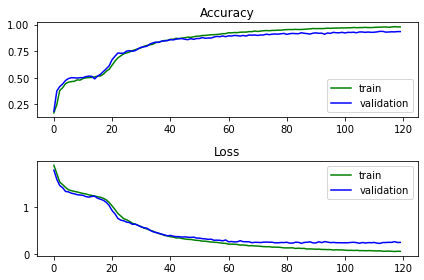

In [40]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [41]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이는 어디야 ?          : 복도      복도
필웅이는 어디야 ?          : 화장실     화장실
경임이는 어디야 ?          : 부엌      부엌
경임이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 부엌      부엌
경임이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 정원      정원
수종이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 사무실     사무실
수종이는 어디야 ?          : 사무실     사무실
필웅이는 어디야 ?          : 부엌      부엌
필웅이는 어디야 ?          : 정원      정원
수종이는 어디야 ?          : 사무실     사무실
필웅이는 어디야 ?          : 침실      침실
필웅이는 어디야 ?          : 침실      침실
은경이는 어디야 ?          : 부엌      부엌
은경이는 어디야 ?          : 정원      정원
은경이는 어디야 ?          : 부엌      부엌
수종이는 어디야 ?          : 사무실     사무실
은경이는 어디야 ?          : 부엌      복도
필웅이는 어디야 ?          : 복도      복도
은경이는 어디야 ?          : 사무실     사무실
은경이는 어디야 ?          : 사무실     사무실
경임이는 어디야 ?          : 복도      복도
수종이는 어디야 ?          : 침실      침실
경임이는 어디야 ?          : 침실      침실
필웅이는 어디야 ?          : 침실      침실
수종이는 어디야 ?          : 부엌      부엌
